# k-armed Bandit Problem

This notebook provides a self-contained implementation of the **k-armed bandit problem** as presented in Chapter 2, Multi-Armed Bandits, of _Reinforcement Learning: An Introduction_ by Sutton and Barto (second edition). We begin with an implementation of the 10-armed testbed as described in the book, using the incremental implementation for the action-value function update rule. We then extend this to a non-stationary problem, as discussed in _Exercise 2.5_ of the chapter, and include a few additional comparisons to illustrate the advantages of using different step-size methods (constant vs. non-constant) in a non-stationary environment.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from collections import defaultdict

rng = np.random.default_rng(42)

Defining a few global variables,

In [2]:
K = 10
N_EXPERIMENTS = 2000
MAX_STEPS = 1000
EPSILONS = [0.0, 0.1, 0.01]
ACTION_SPACE = list(range(K))
N_ACTIONS = len(ACTION_SPACE)

and a plotting function.

In [3]:
def plot_results(average_reward_per_epsilon, optimal_action_prec_per_epsilon, alpha=False):
    colors = ["green", "blue", "red", "orange"]

    x = range(1, MAX_STEPS + 1)
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title("Average reward and % of optimal action")
    if alpha:
        for idx, alp in enumerate(ALPHA):
            color = colors[idx]
            label = f'$\\alpha = {alp}$'
            ax[0].plot(x, average_reward_per_epsilon[alp], label=label, color=color)
            ax[1].plot(x, optimal_action_prec_per_epsilon[alp], label=label, color=color)
    else:
        for idx, epsilon in enumerate(EPSILONS):
            color = colors[idx]
            label = f'$\\epsilon = {epsilon}$'
            if epsilon == 0:
                label += " (greedy)"
            ax[0].plot(x, average_reward_per_epsilon[epsilon], label=label, color=color)
            ax[1].plot(x, optimal_action_prec_per_epsilon[epsilon], label=label, color=color)
    
    ax[1].set_xlabel('Steps')
    ax[0].set_ylabel('Average reward')
    ax[1].set_ylabel('% Optimal action')
    ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0%", "20%", "40%", "60%", "80%", "100%"])
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    

## The 10-armed Testbed

The bandit algorithm as it is described in the book is the following,

![k_armed_bandit_algorithm.png](../assets/k_armed_bandit_algorithm.png)

In [4]:
def bandit(action, true_value_function, variance=1.0):
    value = true_value_function[action]
    return rng.normal(loc=value, scale=np.sqrt(variance))
    
def get_action(epsilon, value_function, optimal_action):
    if rng.random() < epsilon:
        action = rng.choice(ACTION_SPACE)
    else:
        action = max(value_function, key=value_function.get)
    return action, action == optimal_action

def update_value_fucntion(reward, action, value_function, number_function):
    number_function[action] += 1
    value_function[action] = value_function[action] + (reward - value_function[action]) / number_function[action]
    return value_function, number_function

def get_initial_action_values(true_value_function, loc=0.0, variance=1.0):
    for action in ACTION_SPACE:
        initial_value = rng.normal(loc=loc, scale=np.sqrt(variance))
        true_value_function[action] = initial_value
    return true_value_function


In [5]:
%%time
average_reward_per_epsilon = {}
optimal_action_prec_per_epsilon = {}

# A complete experiment loop
for epsilon in EPSILONS:
    average_reward = []
    optimal_action_prec = []
    
    for ex_i in range(N_EXPERIMENTS):
        Q_star = defaultdict(int)                     # true value function
        Q = {action: 0.0 for action in ACTION_SPACE}  # estimated value function
        N = {action: 0 for action in ACTION_SPACE}    # number function
    
        step = 0
        rewards = []
        optimal_actions = []
        done = False
    
        # sample initial action-value values
        Q_star = get_initial_action_values(Q_star)
        optimal_action = max(Q_star, key=Q_star.get)
    
        # run a single experiment
        while not done:
            step += 1
            if step == MAX_STEPS:
                done = True
    
            # get next action
            action, is_optimal = get_action(epsilon, Q, optimal_action)
            
            # apply action and collect reward
            reward = bandit(action, Q_star)
    
            # update number of actions (N) and value function (Q)
            Q, N = update_value_fucntion(reward, action, Q, N)
    
            # compute average reward and optimal action percentage
            rewards.append(reward)
            optimal_actions.append(is_optimal)
            
        # collect experiment data
        average_reward.append(rewards)
        optimal_action_prec.append(optimal_actions)

    # postprocess data per epsilon
    average_reward_per_epsilon[epsilon] = np.mean(np.array(average_reward), axis=0)
    optimal_action_prec_per_epsilon[epsilon] = np.mean(np.array(optimal_action_prec), axis=0)

CPU times: user 8.76 s, sys: 146 ms, total: 8.91 s
Wall time: 8.83 s


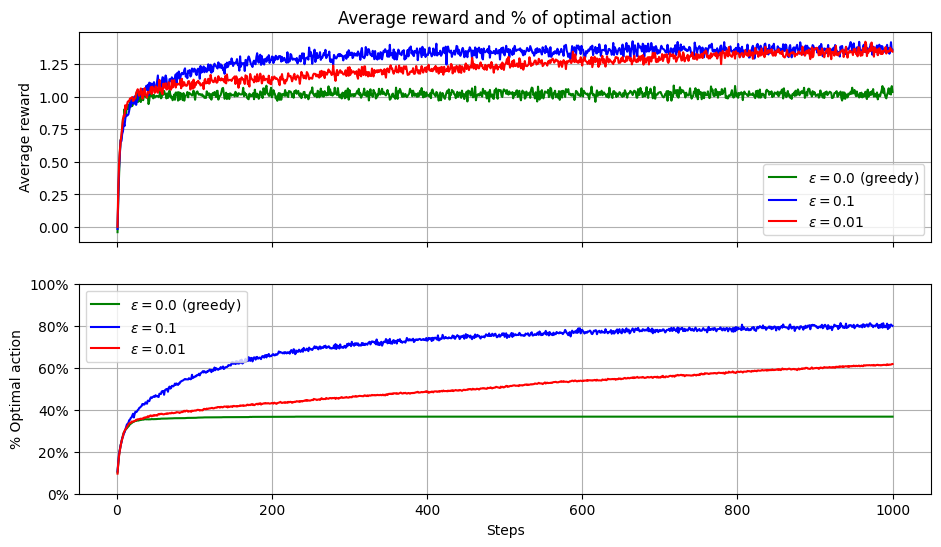

In [6]:
plot_results(average_reward_per_epsilon, optimal_action_prec_per_epsilon)

## Tracking a Nonstationary Problem

_"we often encounter reinforcement learning problems that are effectively nonstationary. In such cases it makes sense to give more weight to recent rewards than to long-past rewards."_ (_Reinforcement Learning: An Introduction_ by Sutton and Barto)

### Exercise 2.5 (Solution)

In [7]:
def get_random_walk_step(loc, scale, size):
    random_walk_step = rng.normal(loc=loc, scale=scale, size=size)
    return random_walk_step

def update_non_stationary_value_fucntion(reward, action, value_function, step_size):
    value_function[action] = value_function[action] + (reward - value_function[action]) * step_size
    return value_function

def get_action(epsilon, value_function, optimal_actions):
    if rng.random() < epsilon:
        action = rng.choice(ACTION_SPACE)
    else:
        action = max(value_function, key=value_function.get)
    return action, action in optimal_actions

In [8]:
K = 10
N_EXPERIMENTS = 2000
MAX_STEPS = 10000
EPSILONS = [0.1]
ACTION_SPACE = list(range(K))
N_ACTIONS = len(ACTION_SPACE)
ALPHA = 0.1                   # step size
RANDOM_WALK_MEAN = 0.0
RANDOM_WALK_STD = 0.01

In [9]:
%%time
average_reward_per_epsilon = {}
optimal_action_prec_per_epsilon = {}

# A complete experiment loop
for epsilon in EPSILONS:
    average_reward = []
    optimal_action_prec = []
    
    for ex_i in range(N_EXPERIMENTS):
        Q_star = {action: 0.2 for action in ACTION_SPACE}   # true value function
        Q = {action: 0.0 for action in ACTION_SPACE}        # estimated value function
    
        step = 0
        rewards = []
        optimal_actions = []
        done = False
    
        # get the optimal action
        optimal_action = ACTION_SPACE
    
        # run a single experiment
        while not done:
            step += 1
            if step == MAX_STEPS:
                done = True
                
            if step > 100:
                # sample a random walk step
                random_walk_step = get_random_walk_step(loc=RANDOM_WALK_MEAN, scale=RANDOM_WALK_STD, size=K)

                # update the true value function
                for act in range(K):
                    Q_star[act] += random_walk_step[act]
                
                # get the NEW optimal action
                optimal_action = [max(Q_star, key=Q_star.get)]

            # get next action
            action, is_optimal = get_action(epsilon, Q, optimal_actions=optimal_action)
                
            # apply action and collect reward
            reward = bandit(action, Q_star)
    
            # update the action-value function (Q)
            Q = update_non_stationary_value_fucntion(reward, action, Q, ALPHA)
    
            # compute average reward and optimal action percentage
            rewards.append(reward)
            optimal_actions.append(is_optimal)
            
        # collect experiment data
        average_reward.append(rewards)
        optimal_action_prec.append(optimal_actions)

    # postprocess data
    average_reward_per_epsilon[epsilon] = np.mean(np.array(average_reward), axis=0)
    optimal_action_prec_per_epsilon[epsilon] = np.mean(np.array(optimal_action_prec), axis=0)

CPU times: user 1min 12s, sys: 509 ms, total: 1min 13s
Wall time: 1min 13s


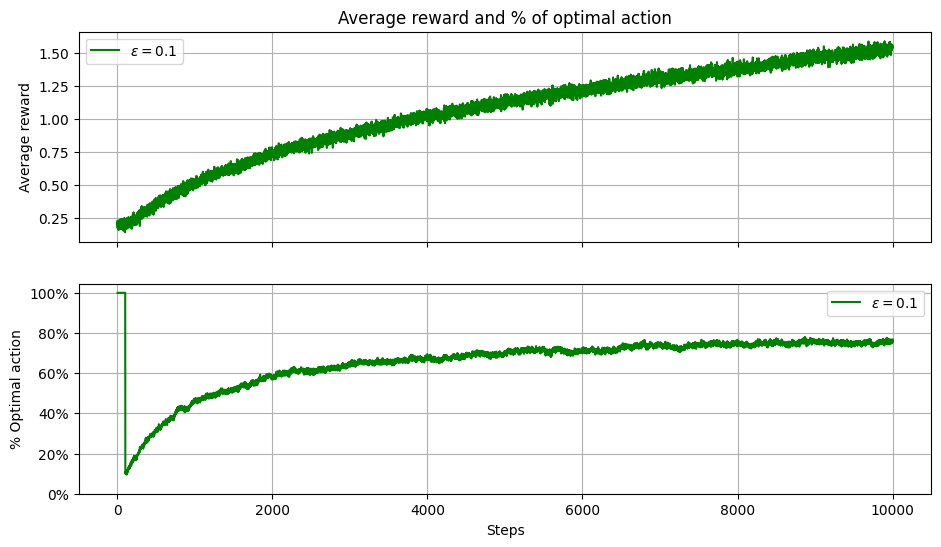

In [10]:
plot_results(average_reward_per_epsilon, optimal_action_prec_per_epsilon)

## Comparison of different step sizes

In the following step-size comparison, we use a random walk with a mean of 0 and a standard deviation of 0.1.
Solving the non-stationary bandit problem under these conditions using a predefined set of step-size functions produces a range of behaviors that highlight the differences between using constant vs. varying step-size functions with different parameter values.

In [11]:
def get_random_walk_step(loc, scale, size):
    random_walk_step = rng.normal(loc=loc, scale=scale, size=size)
    return random_walk_step

def update_value_fucntion(reward, action, value_function, number_function, step_size=None):
    if step_size == "1/n":
        number_function[action] += 1
        value_function[action] = value_function[action] + (reward - value_function[action]) / number_function[action]
    elif step_size == "1/n^2":
        number_function[action] += 1
        value_function[action] = value_function[action] + (reward - value_function[action]) / (number_function[action] * number_function[action])
    elif isinstance(step_size, float):
        value_function[action] = value_function[action] + (reward - value_function[action]) * step_size
    return value_function, number_function

def get_action(epsilon, value_function, optimal_actions):
    if rng.random() < epsilon:
        action = rng.choice(ACTION_SPACE)
    else:
        action = max(value_function, key=value_function.get)
    return action, action in optimal_actions

In [15]:
K = 10
N_EXPERIMENTS = 1000
MAX_STEPS = 10000
EPSILONS = [0.1]
ACTION_SPACE = list(range(K))
N_ACTIONS = len(ACTION_SPACE)
ALPHA = [0.01, 0.1, "1/n", "1/n^2"]   # step size
RANDOM_WALK_MEAN = 0.0
RANDOM_WALK_STD = 0.1 

In [16]:
%%time
average_reward_per_alpha = {}
optimal_action_prec_per_alpha = {}

# A complete experiment loop
for alpha in ALPHA:
    average_reward = []
    optimal_action_prec = []
    
    for ex_i in range(N_EXPERIMENTS):
        Q_star = {action: 0.2 for action in ACTION_SPACE}   # true value function
        Q = {action: 0.0 for action in ACTION_SPACE}        # estimated value function
        N = {action: 0 for action in ACTION_SPACE}          # number function
    
        step = 0
        rewards = []
        optimal_actions = []
        done = False
    
        # get the optimal action
        optimal_action = ACTION_SPACE
    
        # run a single experiment
        while not done:
            step += 1
            if step == MAX_STEPS:
                done = True
                
            if step > 100:
                # sample a random walk step
                random_walk_step = get_random_walk_step(loc=RANDOM_WALK_MEAN, scale=RANDOM_WALK_STD, size=K)

                # update the true value function
                for act in range(K):
                    Q_star[act] += random_walk_step[act]
                
                # get the NEW optimal action
                optimal_action = [max(Q_star, key=Q_star.get)]

            # get next action
            action, is_optimal = get_action(EPSILONS[0], Q, optimal_actions=optimal_action)
                
            # apply action and collect reward
            reward = bandit(action, Q_star)
    
            # update number of actions (N) and action-value function (Q) using various step-size functions
            Q, N = update_value_fucntion(reward, action, Q, number_function=N, step_size=alpha)
    
            # compute average reward and optimal action percentage
            rewards.append(reward)
            optimal_actions.append(is_optimal)
            
        # collect experiment data
        average_reward.append(rewards)
        optimal_action_prec.append(optimal_actions)

    # postprocess data per step-size function (alpha)
    average_reward_per_alpha[alpha] = np.mean(np.array(average_reward), axis=0)
    optimal_action_prec_per_alpha[alpha] = np.mean(np.array(optimal_action_prec), axis=0)

CPU times: user 2min 32s, sys: 1.03 s, total: 2min 33s
Wall time: 2min 33s


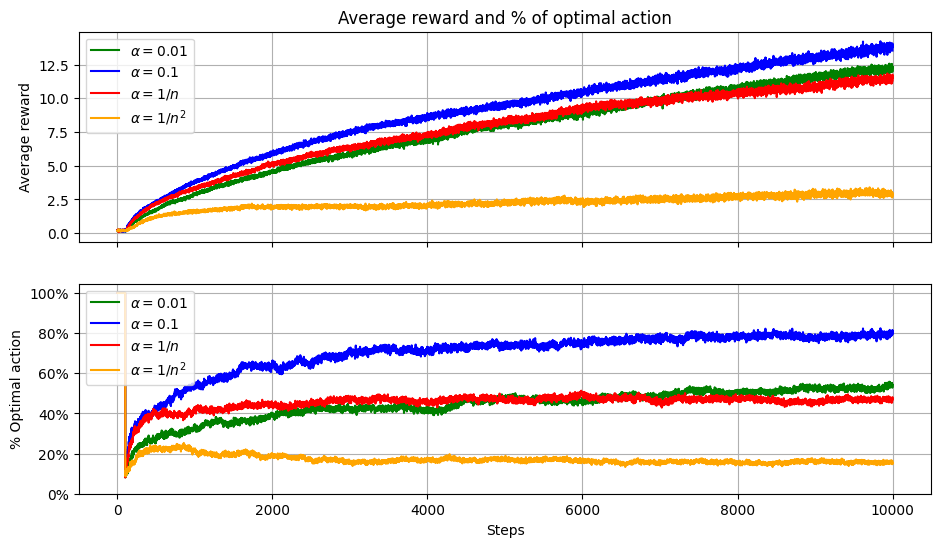

In [18]:
plot_results(average_reward_per_alpha, optimal_action_prec_per_alpha, alpha=True)